# Investigation

This will be my attempt at creating something similar to the original notebook.
A few things to think about:

- After doing the initial recreation, let's look at the Kaggle tutorials and add in other data points
  - Close - n datapoints? So we're not just using the very latest close price
  - High/Low/Open - see if these are useful
  - Tick volume - see if this is useful
- As well as looking at root mean squared error, lets look at statistics
  - When model predict a move of more than 1, 2, 3 ATR in next 10, 15 candles, how often does this actually happen?
    - When it's correct, how often is there a move in the opposite direction first that was not seen by model
  - When it predicts a positive or negative move, how often is it actually correct?
    - Look at this over different candle counts. ie. Candle 1, 10, 15
- Rather than predict the price, try predict the change?
  - The price may hit values never encountered in training which may make it harder to predict

Hopefully, we will find models that are better than the original but there's not going to be a model we can use for native price forcasting. But perhaps we can use it to inform other prediction algorithms. ie. If we have an algorithm that identifies support and resistance areas, and the model is good a predicting the direction of the movement then it can be used to inform on where to place a trade even if it can't predict the price.

### Note

In this repo I am using a custom module `malfoy.metatrader` that I built on top of the `MetaTrader5` package. This interfaces directly with MetaTrader to pull up-to-date data. I hope to eventually make this open-source but for now it's a private module. I have also saved the data used in `./data/new` so it can be reused.

In [96]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib widget

In [97]:
# Functions

def CreateScaler(data: pd.Series) -> MinMaxScaler:
  data = np.array(data).reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)

  return scaler

def GetScaledData(data: pd.Series, scaler: MinMaxScaler) -> pd.Series:
  data = np.array(data).reshape(-1, 1)
  return scaler.transform(data)

def GetTimeStepDataFrame(data: pd.DataFrame, timeSteps: int, trainingColumns: list, predictionColumn: str) -> pd.DataFrame:
  
  timeStepData = pd.DataFrame(index=data.index)

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].shift(i)

  timeStepData[predictionColumn] = data[predictionColumn]
  
  timeStepData = timeStepData.dropna()

  return timeStepData

def GetTimeStepDict(data: pd.DataFrame, timeSteps: int, trainingColumns: list) -> dict:
  
  timeStepData = {}

  for column in trainingColumns:
    for i in range(1, timeSteps + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].iloc[timeSteps - i]

  return timeStepData

## Variables

These core variables are used throughout the scripts. The instrument and granularity variables can be used to change the target of predictions. These correspond to the data found in `./data/new/`

*Prediction Variables*:
- instrument - the instrument being predicted
- granularity - the timeframe being predicted on (One minute, one hour, one day, etc)
- predictionTimeSteps - the number of previous time steps to use in making the prediction for the current candle
- predictionColumn - the column from the dataframe we are trying to predict

In [98]:
# Set script variables
seedValue = 72
trainingSizePercent = 0.7
inputDataFolder = "./input/new"

# Change these for prediction changes
instrument = "USDCAD"
granularity = "H1"
predictionTimeSteps = 15
predictionColumn = "midCloseDelta"

In [99]:
# Import data

rawDataFilePath = "{0}/{1}_{2}.csv".format(inputDataFolder, instrument, granularity)
rawData = pd.read_csv(rawDataFilePath)

rawData

,Unnamed: 0,instrument,granularity,time,stringTime,volume,bidOpen,bidHigh,bidLow,bidClose,midOpen,midHigh,midLow,midClose,askOpen,askHigh,askLow,askClose
0,0,USDCAD,H1,2021-07-02 03:00:00,2021-07-02T03:00:00,1760,1.24402,1.24412,1.24355,1.24411,1.24402,1.24412,1.24355,1.24411,1.24402,1.24412,1.24355,1.24411
1,1,USDCAD,H1,2021-07-02 04:00:00,2021-07-02T04:00:00,2019,1.24411,1.24440,1.24355,1.24385,1.24411,1.24440,1.24355,1.24385,1.24411,1.24440,1.24355,1.24385
2,2,USDCAD,H1,2021-07-02 05:00:00,2021-07-02T05:00:00,1745,1.24385,1.24407,1.24306,1.24329,1.24385,1.24407,1.24306,1.24329,1.24385,1.24407,1.24306,1.24329
3,3,USDCAD,H1,2021-07-02 06:00:00,2021-07-02T06:00:00,1133,1.24329,1.24347,1.24298,1.24306,1.24329,1.24347,1.24298,1.24306,1.24329,1.24347,1.24298,1.24306
4,4,USDCAD,H1,2021-07-02 07:00:00,2021-07-02T07:00:00,881,1.24306,1.24313,1.24274,1.24305,1.24306,1.24313,1.24274,1.24305,1.24306,1.24313,1.24274,1.24305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,USDCAD,H1,2022-04-20 08:00:00,2022-04-20T08:00:00,1371,1.25828,1.25885,1.25802,1.25848,1.25828,1.25885,1.25802,1.25848,1.25828,1.25885,1.25802,1.25848
4996,4996,USDCAD,H1,2022-04-20 09:00:00,2022-04-20T09:00:00,2204,1.25850,1.25890,1.25770,1.25791,1.25850,1.25890,1.25770,1.25791,1.25850,1.25890,1.25770,1.25791
4997,4997,USDCAD,H1,2022-04-20 10:00:00,2022-04-20T10:00:00,4017,1.25790,1.25876,1.25685,1.25782,1.25790,1.25876,1.25685,1.25782,1.25790,1.25876,1.25685,1.25782
4998,4998,USDCAD,H1,2022-04-20 11:00:00,2022-04-20T11:00:00,2644,1.25783,1.25811,1.25619,1.25635,1.25783,1.25811,1.25619,1.25635,1.25783,1.25811,1.25619,1.25635


In [100]:
# Pre-process data

ppData = rawData.copy()

# New columns
ppData["askCloseDelta"] = ppData["askClose"] - ppData["askClose"].shift(1)
ppData["midCloseDelta"] = ppData["midClose"] - ppData["midClose"].shift(1)
ppData["bidCloseDelta"] = ppData["bidClose"] - ppData["bidClose"].shift(1)

# Split data in to test and train
trainingEntryCount = math.floor(len(ppData) * trainingSizePercent)
trainingData = ppData.iloc[0:trainingEntryCount, :]
testData = ppData.iloc[trainingEntryCount:len(ppData), :]

# Scale required columns
scaledColumns = ["bidOpen", "bidHigh", "bidLow", "midOpen", "midHigh", "midLow", "askOpen", "askHigh", "askLow", "volume", "bidClose", "midClose", "askClose", "midCloseDelta"]

scalerDict = {}

for column in scaledColumns:
  scalerDict[column] = CreateScaler(trainingData[column])
  
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
  testData[column] = GetScaledData(testData[column], scalerDict[column])

# Add previous time steps as data available for making prediction
trainingColumns = ["midClose", "midCloseDelta"]

trainingTimeStepData = GetTimeStepDataFrame(trainingData, timeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_trainingData = trainingTimeStepData.drop(columns=predictionColumn)
Y_trainingData = trainingTimeStepData[predictionColumn]

testTimeStepData = GetTimeStepDataFrame(testData, timeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_testData = testTimeStepData.drop(columns=predictionColumn)
Y_testData = testTimeStepData[predictionColumn]

print("X_trainingData shape:", X_trainingData.shape)
print("Y_trainingData shape:", Y_trainingData.shape)
print("X_testData shape:", X_testData.shape)
print("Y_testData shape:", Y_testData.shape)

X_trainingData.to_csv("./train.csv")
trainingData.to_csv("./train_raw.csv")
X_testData.to_csv("./test.csv")
testData.to_csv("./test_raw.csv")

C:\Users\sambe\AppData\Local\Temp\ipykernel_24712\3544916736.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_24712\3544916736.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData[column] = GetScaledData(testData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_24712\3544916736.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

X_trainingData shape: (3485, 15)
Y_trainingData shape: (3485,)
X_testData shape: (1485, 15)
Y_testData shape: (1485,)


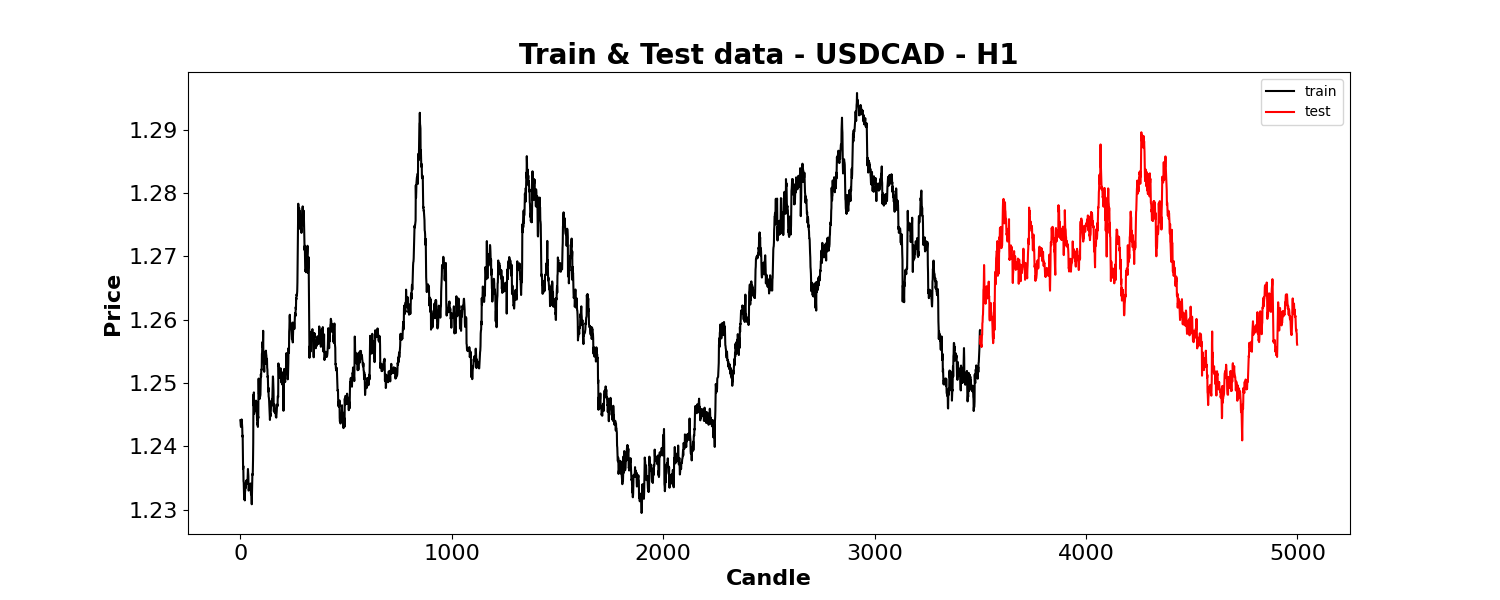

In [101]:
# Plot test and train data

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')

# Formatting
ax.set_title('Train & Test data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [102]:
# Train model

model = XGBRegressor(n_estimators=10000, seed=seedValue)
model.fit(X_trainingData, Y_trainingData, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=72,
             reg_alpha=0, reg_lambda=1, ...)

In [103]:
# Model testing and evaluation

predictions = model.predict(X_testData)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_testData, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_testData, predictions))))

Mean Absolute Error - MAE : 0.06982374693929384
Root Mean squared Error - RMSE : 0.0935461130830632


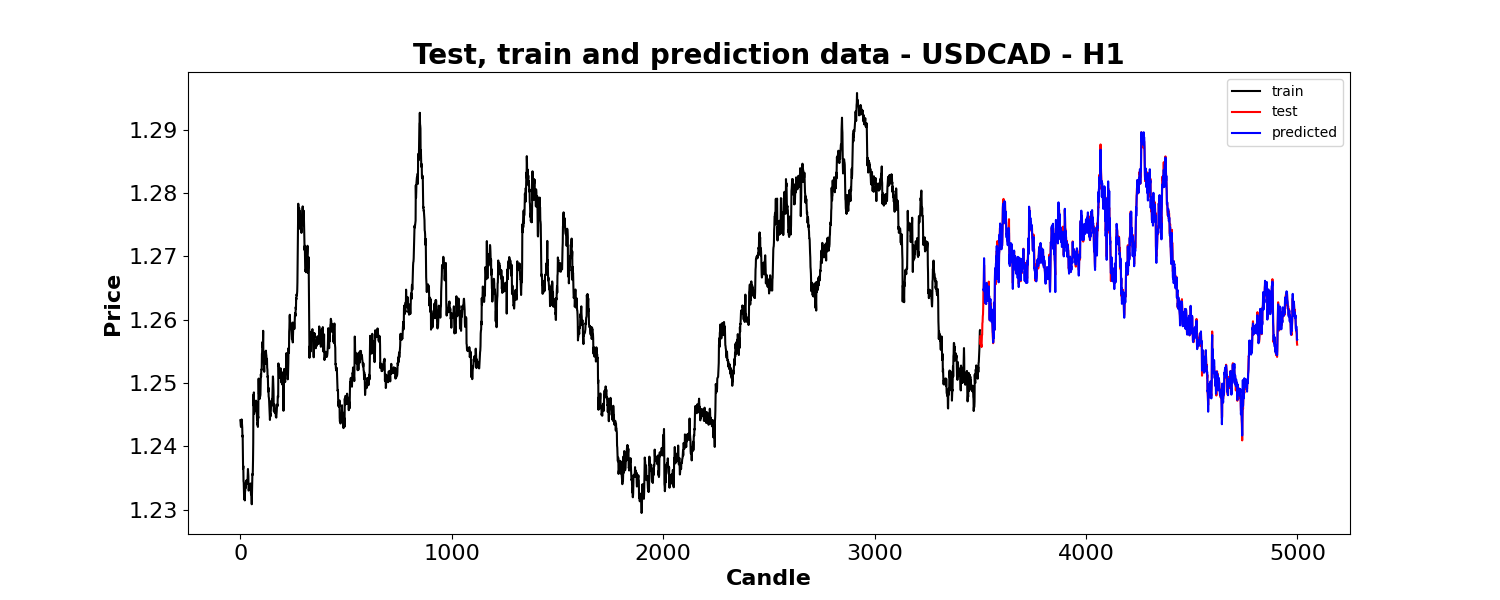

In [104]:
# Plot the predicted vs actual
plotTestData = X_testData.copy()

plotTestData["midClose"] = testData["midClose"]
plotTestData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestData["midClose"]).reshape(-1, 1))
plotTestData["PredictedValue"] = scalerDict[predictionColumn].inverse_transform(np.array(predictions).reshape(-1, 1))
plotTestData["PredictedValue"] = plotTestData["PredictedValue"] + plotTestData["midClose"]

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedValue'], color = 'blue')

# Formatting
ax.set_title('Test, train and prediction data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test', "predicted"))


## Future prediction

This next part is an attempt to use previous predictions to then predict the next step. This will obviously not be as accurate as predicting one step ahead for two reasons:
- The further in the future you are trying to predict, the higher the uncertainty.
- We will be using previous predictions as inputs to the next prediction. This will add error and more uncertainty.

In [105]:
futureTestData = testData.copy().head(predictionTimeSteps)

stepsToPredict = 10

# Sets the index value for the next dataframe entry
nextIndexValue = futureTestData.index.values[-1] + 1

for i in range(stepsToPredict):
  previousClose = scalerDict["midClose"].inverse_transform(np.array(futureTestData["midClose"].values[-1]).reshape(-1, 1))

  # Get values needed to predict next step
  nextTimeStep = GetTimeStepDict(futureTestData.tail(predictionTimeSteps), timeSteps=predictionTimeSteps, trainingColumns=trainingColumns)
  
  # Predict next step
  prediction = model.predict(pd.DataFrame(nextTimeStep, index=[nextIndexValue]))[0]
  
  # Store predictions in dataframe
  nextTimeStep[predictionColumn] = prediction
  predictionUnscaled = scalerDict[predictionColumn].inverse_transform(np.array(prediction).reshape(-1, 1))
  
  predictedClose = previousClose + predictionUnscaled
  nextTimeStep["midClose"] = scalerDict["midClose"].transform(predictedClose)[0][0]
  nextTimeStep["midCloseDelta"] = scalerDict["midCloseDelta"].transform(predictedClose - previousClose)[0][0]

  futureTestData = pd.concat([futureTestData, pd.DataFrame(nextTimeStep, index=[nextIndexValue])])

  nextIndexValue = nextIndexValue + 1

print(futureTestData[["midClose", "midCloseDelta"]])

      midClose  midCloseDelta
3500  0.420600       0.397454
3501  0.401448       0.376238
3502  0.413965       0.524752
3503  0.405067       0.424328
3504  0.401297       0.448373
3505  0.400241       0.461103
3506  0.395114       0.442008
3507  0.409742       0.534653
3508  0.423767       0.531825
3509  0.424069       0.467468
3510  0.451968       0.596888
3511  0.454230       0.476662
3512  0.468858       0.534653
3513  0.472779       0.484441
3514  0.492384       0.557992
3515  0.492920       0.468568
3516  0.489770       0.451279
3517  0.493551       0.483787
3518  0.490465       0.451583
3519  0.489237       0.460294
3520  0.489836       0.468864
3521  0.493147       0.481580
3522  0.494861       0.474090
3523  0.490819       0.447100
3524  0.491956       0.471384


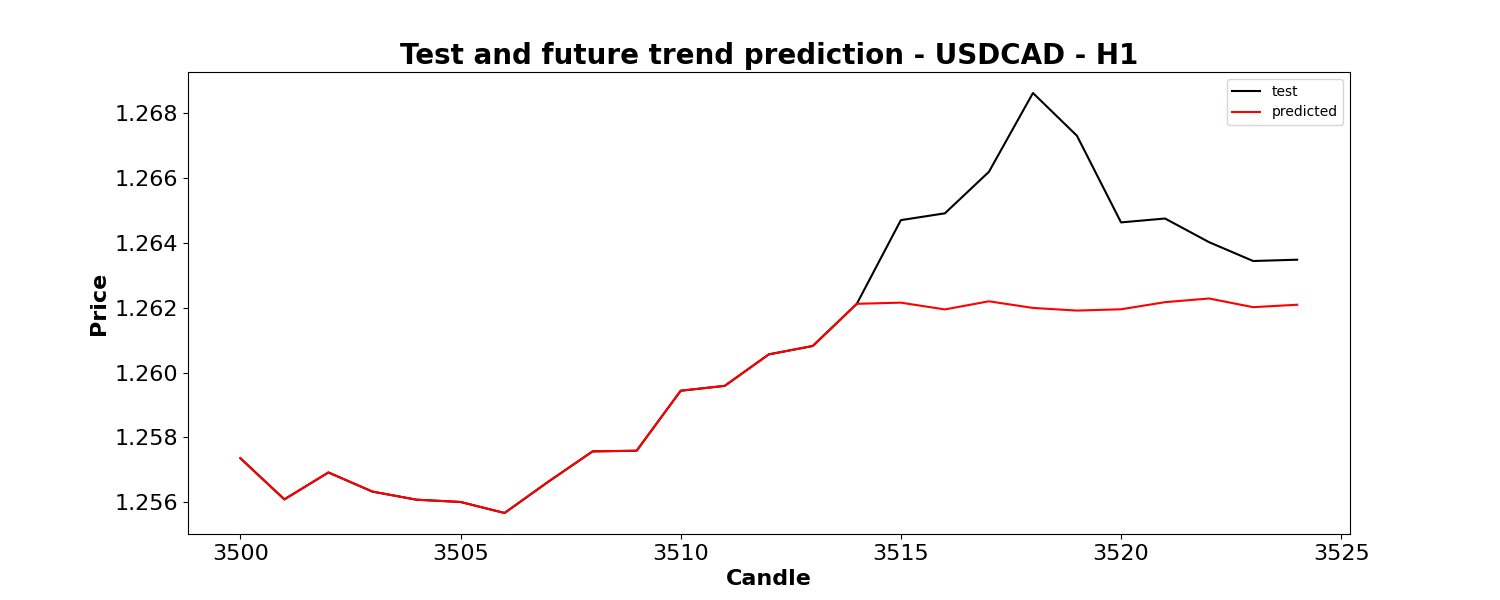

In [106]:
# Plot predicted steps
plotFutureData = futureTestData.copy()

plotTestSubset = testData.loc[plotFutureData.index.values]

plotFutureData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotFutureData["midClose"]).reshape(-1, 1))
plotTestSubset["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestSubset["midClose"]).reshape(-1, 1))

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = plotTestSubset.index.values, y = plotTestSubset['midClose'], color = 'black')
sns.lineplot(x = plotFutureData.index.values, y = plotFutureData['midClose'], color = 'red')

# Formatting
ax.set_title('Test and future trend prediction - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('test', "predicted"))